# Explore basins and states: all-to-all

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from tqdm import tqdm

sys.path.append("../code/")

import xgi
from kuramoto_hoi import *

sb.set_theme(style="ticks", context="notebook")

results_dir = "../results/"
data_dir = "../data/"

Path(results_dir).mkdir(parents=True, exist_ok=True)
Path(data_dir).mkdir(parents=True, exist_ok=True)

## Generate structure

In [92]:
N = 10
H = xgi.complete_hypergraph(N, max_order=2)

#H = xgi.ring_lattice(N, 2, 4, 0)

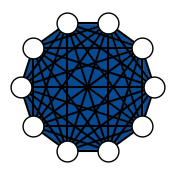

In [93]:
fig, ax = plt.subplots(figsize=(2, 2))
pos = xgi.circular_layout(H)

xgi.draw(H, pos=pos, ax=ax)

plt.show()

In [94]:
# may be used in the simulation function
links = H.edges.filterby("size", 2).members()
triangles = H.edges.filterby("size", 3).members()
adj1 = xgi.adjacency_matrix(H, order=1)
adj2 = xgi.adjacency_matrix(H, order=2)
k1_avg = H.nodes.degree(order=1).mean()
k2_avg = H.nodes.degree(order=2).mean()

In [95]:
len(triangles)

120

In [96]:
from math import sin

In [138]:
def rhs_a2a_micro(t, psi, omega, k1, k2, links, triangles, alpha):
    """Right-hand side of the ODE.
    Only pairwise.
    Coupling function: sin(oj - oi + alpha) + sin(oj + ok - 2oi)

    Parameters
    ----------
    t: float
        Time
    psi: array of float
        Phases to integrate
    """

    N = len(psi)
    sin_psi = np.sin(psi)
    cos_psi = np.cos(psi)

    sum_cos_psi = np.sum(np.cos(psi+alpha))
    sum_sin_psi = np.sum(np.sin(psi+alpha))

    # oj - oi
    pairwise = -sum_cos_psi * sin_psi + sum_sin_psi * cos_psi
    #pairwise = np.zeros(N)

    #for i, j in links:
    #    # sin(oj - oi)
    #    oi = psi[i]
    #    oj = psi[j]
    #    pairwise[i] += sin(oj - oi)
    #    pairwise[j] += sin(oi - oj)
        
    triplet = np.zeros(N)

    for i, j, k in triangles:
        # sin(oj - ok - 2 oi)
        oi = psi[i]
        oj = psi[j]
        ok = psi[k]
        triplet[i] += 2 * sin(oj + ok - 2 * oi)
        triplet[j] += 2 * sin(oi + ok - 2 * oj)
        triplet[k] += 2 * sin(oj + oi - 2 * ok)

    return omega + (k1 / N) * pairwise + (k2 / N**2) * triplet / 2

In [136]:
psi_init = generate_state(N, kind="random", k=2, ps=[0.3, 0.7], noise=0)

rhs_a2a_micro(0, np.zeros(N), omega=0, k1=0, k2=1, links=links, triangles=triangles, alpha=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Dynamics

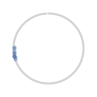

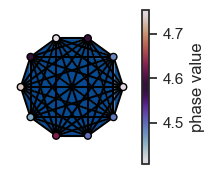

In [230]:
# Set parameters

# dynamical
k1 = 1  # pairwise coupling strength
k2 = 2  # triplet coupling strength
omega = 1 * np.ones(N)  # np.random.normal(size=N) #1 * np.ones(N)

alpha = np.pi / 3

ic = "random"  # initial condition type, see below
noise = 1e-1  # noise strength
p2 = None


psi_init = generate_state(N, kind="k-cluster", k=2, ps=[0.3, 0.7], noise=noise)

# integration
t_end = 400
dt = 0.01
times = np.arange(0, t_end + dt / 2, dt)

tag_params = f"k1_{k1}_k2_{k2}_ic_{ic}"

fig, ax = plt.subplots(figsize=(1, 1))
plot_phases(psi_init, it=None, ax=ax)
plt.show()

# only to viz twisted states
fig, ax = plt.subplots(figsize=(2, 2))
ax, im = xgi.draw(
    H, pos=pos, node_fc=psi_init % (2 * np.pi), node_fc_cmap="twilight", node_size=5
)
plt.colorbar(im, label="phase value")

In [231]:
n_reps = 10

# simulate
kwargs = {
    #"adj1": adj1,
    "links": links,
    "triangles": triangles,
    #    "k1_avg": k1_avg,
    #    "k2_avg": k2_avg,
    "alpha": alpha
}

thetas_arr = np.zeros((n_reps, N, len(times)))

for i in tqdm(range(n_reps)):
    psi_init = generate_state(N, kind="random", k=2, ps=[0.3, 0.7], noise=0.005)

    thetas, times = simulate_kuramoto(
        H,
        k1,
        k2,
        omega=omega,
        theta_0=psi_init,
        t_end=t_end,
        dt=dt,
        rhs=rhs_a2a_micro,  # rhs_pairwise_all
        **kwargs
    )

    thetas_arr[i] = thetas

100%|███████████████████████████████████████████| 10/10 [00:50<00:00,  5.05s/it]


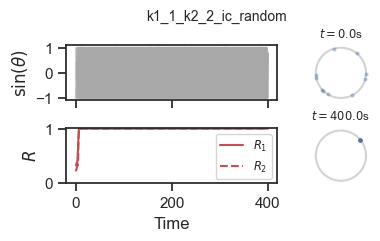

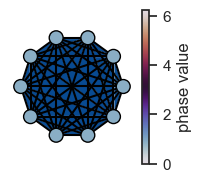

In [232]:
# plot the last repetition
i = 4
fig, axs = plot_sync(thetas_arr[i], times)

axs[0, 1].set_title(f"$t={times[0]}$s", fontsize="x-small")
axs[1, 1].set_title(f"$t={times[-1]}$s", fontsize="x-small")

axs[0, 0].set_xlabel("")
axs[1, 0].legend(loc="best", fontsize="x-small")

plt.subplots_adjust(hspace=0.5, top=0.8)

fig.suptitle(tag_params, fontsize="small")

# only to viz twisted states
fig, ax = plt.subplots(figsize=(2, 2))
ax, im = xgi.draw(
    H,
    pos=pos,
    node_fc=thetas_arr[i, :, -1] % (2 * np.pi),
    node_fc_cmap="twilight",
    node_size=10,
    vmin=0, 
    vmax=2*np.pi
)
plt.colorbar(im, label="phase value")

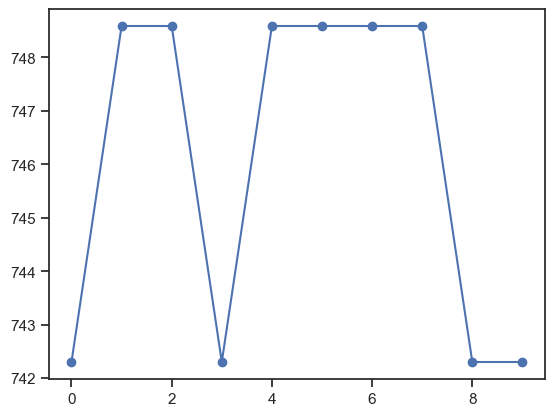

In [233]:
plt.plot(thetas_arr[i, :, -1], "o-")

In [234]:
thetas_arr.shape

(10, 10, 40001)

In [235]:
states = [identify_state(thetas, atol=0.01) for thetas in thetas_arr]
set(states)

{'sync'}

In [236]:
states_unique, counts = np.unique(states, return_counts=True)
states_unique, counts

(array(['sync'], dtype='<U4'), array([10]))

In [237]:
states

['sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync',
 'sync']

(array([ 0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

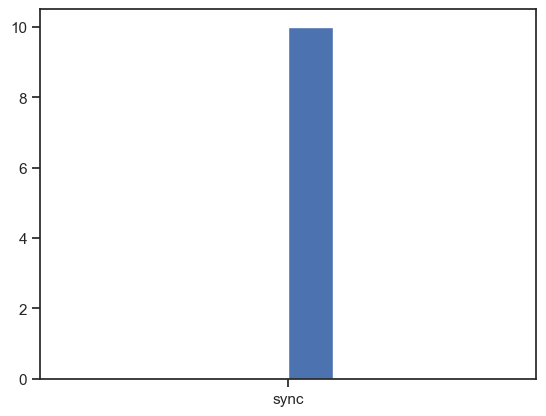

In [238]:
plt.hist(states)

## Loop over k2

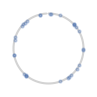

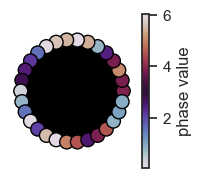

In [142]:
# Set parameters

# dynamical
k1 = 1  # pairwise coupling strength
k2 = 0  # triplet coupling strength
omega = 1 * np.ones(N)  # np.random.normal(size=N) #1 * np.ones(N)

ic = "random"  # initial condition type, see below
noise = 1e-1  # noise strength
p2 = None


psi_init = generate_state(N, kind=ic, q=2, noise=noise)

# integration
t_end = 200
dt = 0.01
times = np.arange(0, t_end + dt / 2, dt)

tag_params = f"k1_{k1}_k2_{k2}_ic_{ic}"

fig, ax = plt.subplots(figsize=(1, 1))
plot_phases(psi_init, it=None, ax=ax)
plt.show()

# only to viz twisted states
fig, ax = plt.subplots(figsize=(2, 2))
ax, im = xgi.draw(
    H, pos=pos, node_fc=psi_init % (2 * np.pi), node_fc_cmap="twilight", node_size=1
)
plt.colorbar(im, label="phase value")

In [171]:
n_reps = 100

k2s = [0, 0.5, 1, 1.5, 2, 2.5]

# simulate
# kwargs = {
#    "links": links,
#    "triangles": triangles,
#    "k1_avg": k1_avg,
#    "k2_avg": k2_avg,
# }

thetas_arr = np.zeros((n_reps, len(k2s), N, len(times)))

for j, k2 in enumerate(k2s):
    for i in tqdm(range(n_reps)):
        psi_init = generate_state(N, kind="random", noise=noise)

        thetas, times = simulate_kuramoto(
            H,
            k1,
            k2,
            omega=omega,
            theta_0=psi_init,
            t_end=t_end,
            dt=dt,
            rhs=rhs_pairwise_triplet_all_asym,  # rhs_pairwise_all  #rhs_triplet_all_asym
            # **kwargs
        )

        thetas_arr[i, j] = thetas

100%|█████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s]


In [172]:
results = {}

for j, k2 in enumerate(tqdm(k2s)):
    states = [identify_state(thetas, atol=0.5) for thetas in thetas_arr[:, j]]
    states_unique, counts = np.unique(states, return_counts=True)
    probs = counts / n_reps

    results[k2] = {}
    for state, prob in zip(states_unique, probs):
        results[k2][state] = prob

100%|█████████████████████████████████████████████| 6/6 [00:22<00:00,  3.74s/it]


In [173]:
results

{0: {'sync': 1.0},
 0.5: {'sync': 1.0},
 1: {'sync': 1.0},
 1.5: {'sync': 1.0},
 2: {'sync': 1.0},
 2.5: {'sync': 1.0}}

In [174]:
import pandas as pd

In [175]:
df = pd.DataFrame.from_dict(results, orient="index").reset_index(names="k2")
df

,k2,sync
0,0.0,1.0
1,0.5,1.0
2,1.0,1.0
3,1.5,1.0
4,2.0,1.0
5,2.5,1.0


In [176]:
df_long = df.melt(id_vars="k2", var_name="state", value_name="proba")
df_long

,k2,state,proba
0,0.0,sync,1.0
1,0.5,sync,1.0
2,1.0,sync,1.0
3,1.5,sync,1.0
4,2.0,sync,1.0
5,2.5,sync,1.0


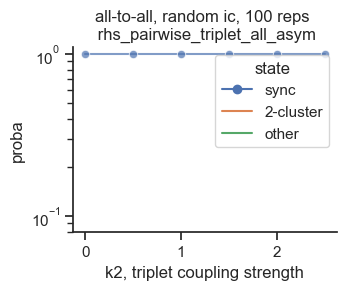

In [178]:
fig, ax = plt.subplots(figsize=(3.4, 2.4))
g = sb.lineplot(
    data=df_long,
    x="k2",
    y="proba",
    hue="state",
    markers=True,
    ax=ax,
    alpha=0.7,
    style="state",
    hue_order=["sync", "2-cluster", "other"],
)

g.set(yscale="log")

ax.set_xlabel("k2, triplet coupling strength")

title = f"all-to-all, {ic} ic, {n_reps} reps \n rhs_pairwise_triplet_all_asym"
ax.set_title(title)


sb.despine()
ax.set_ylim(ymax=1.1)

fig_name = f"basin_size_a2a_ic_{ic}_nreps_{n_reps}_rhs_pairwise_triplet_all_asym"

plt.savefig(f"{results_dir}{fig_name}.png", dpi=300, bbox_inches="tight")

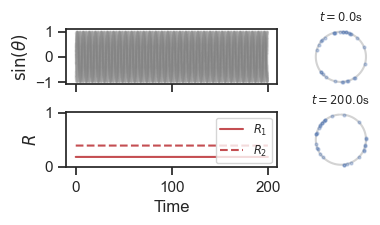

In [151]:
# plot the last repetition
i = 2
j = 0
fig, axs = plot_sync(thetas_arr[i, j], times)

axs[0, 1].set_title(f"$t={times[0]}$s", fontsize="x-small")
axs[1, 1].set_title(f"$t={times[-1]}$s", fontsize="x-small")

axs[0, 0].set_xlabel("")
axs[1, 0].legend(loc="best", fontsize="x-small")

plt.subplots_adjust(hspace=0.5, top=0.8)

# fig.suptitle(tag_params, fontsize="small")

In [148]:
dat = np.load("../code/thetas_arr.npy")

In [149]:
dat.shape

(100, 6, 30, 20001)

In [152]:
results = {}
k2s = [0, 0.5, 1, 1.5, 2, 2.5]

for j, k2 in enumerate(tqdm(k2s)):
    states = [identify_state(thetas, atol=0.5) for thetas in dat[:, j]]
    states_unique, counts = np.unique(states, return_counts=True)
    probs = counts / n_reps

    results[k2] = {}
    for state, prob in zip(states_unique, probs):
        results[k2][state] = prob

100%|█████████████████████████████████████████████| 6/6 [00:21<00:00,  3.60s/it]


In [153]:
results

{0: {'sync': 1.0},
 0.5: {'sync': 1.0},
 1: {'sync': 1.0},
 1.5: {'sync': 1.0},
 2: {'sync': 1.0},
 2.5: {'sync': 1.0}}

In [247]:
H.nodes.neighbors

<bound method IDView.neighbors of NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9))>